In [1]:
import SiemensQuadraProperties as sqp
from ActivityTools import *
from SimulationDataset import *

from multiprocessing import Pool
import random
import numpy as np
import matplotlib.pyplot as mpl
myColours=[]
for colour in mpl.cm.viridis( np.linspace( 0.05, 0.8, 4 ) ):
    myColours.append( colour )
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=myColours)

params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "lower right",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

The NEMU NU 2-2012 calculation for variation of NECR with source activity, although now we are only interested in the maximum value

In [2]:
def NECRatTimeF18(tracerData, crystalData, detectorRadius, phantomLength, stableActivity = 0,simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):

    # NEMU NU 2-2012 says 650mm window for 700mm phantom, so keep the same relation
    zWindow = (phantomLength - 50) / 2
    
    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm
    
    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        #activity = F18ActivityAtTime( 1100E6, timeSec )
        activity = stableActivity

        necr, true, rPlusS = DetectedCoincidences( [activity],[tracerData], simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        activityAtTime.append( activity / phantomVolume )
    
    mpl.clf()
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime

WARNING: this calculation will take a long time

We choose a range of test detector lengths (the real lengths are calculated using discrete detector component sizes) and for each one find the peak NECR value with a given source. We then repeat for a range of different source lengths. This requires a large amount of simulation and calculation of the decay coincidences.

Both the simulation window size and the dataset size will have a significant impact on the total calculation time. Existing datasets will be re-used automatically (mitigating this issue somewhat) and the simulation window has the greatest effect on statistical fluctuation in the result (10ms window recommended, but this will be slow)

Although the simulation and the coincidence calculation are single-threaded, they can be run completely in parallel. A simple multiprocessing model gives close to ideal scaling - 10 processes are used by default, but adjust this to suit your system

In [18]:
# Investigate ideal detector length with Siemens geometry
def OneDetector( detectorLength, phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):
    
    # Fix random seed for reproducibility, don't if you want variation
    # Has to be set in this method, not before, because this is where we enter the worker processes
    random.seed( detectorLength )
    
    tracerData = CreateDataset( detectorLength, "Siemens", phantomLength, "LinearF18", 1000000, 435.0, 585.0 )
    crystalData = CreateDataset( detectorLength, "Siemens", phantomLength, "Siemens", 1000000, 435.0, 585.0 )
    crystalActivity = 0.0

    activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, rPlusSAtTimeSiemens = NECRatTimeF18( tracerData, crystalData, crystalActivity, sqp.DetectorRadius(), phantomLength, simulationWindow, coincidenceWindow )

    return ( max( necrAtTimeSiemens ), sqp.DetectorDiscreteLength( detectorLength ) )

def PeakNECRWithLengthMultiprocess( phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9, processes=5 ):
    
    # Create the arguments for each process
    detectorLengths = [ 100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900 ]
    arguments = []
    for detectorLength in detectorLengths:
        arguments.append( ( detectorLength, phantomLength, simulationWindow, coincidenceWindow ) )
    
    # Launch a separate process for each detector length
    result = None
    with Pool( processes=processes ) as p:
        result = p.starmap( OneDetector, arguments )
    
    # Unpack the results
    realLengths = []
    maxNECR = []
    for entry in result:
        maxNECR.append( entry[0] )
        realLengths.append( entry[1] )
    return realLengths, maxNECR

detectorLengths = []
maxNECRlines = []
trialPhantoms = [ 300, 700, 1100, 1500 ]
for phantomLength in trialPhantoms:
    detectorLengths, maxNECR = PeakNECRWithLengthMultiprocess( phantomLength, simulationWindow=1E-3 )
    maxNECRlines.append( maxNECR )


Re-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulation




34157.0 events loaded (1000000 simulated) with average 1.0354539333079602 hits/event
47305.0 events loaded (1000000 simulated) with average 1.0953810379452489 hits/event
49836.0 events loaded (1000000 simulated) with average 1.1336985311822778 hits/event
../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 100 --source Siemens --phantomLengthMM 300 --outputFileName hits.n1000000.SiemensBlock.100mm.Siemens.300mm.1234.csv --randomSeed 1234
55097.0 events loaded (1000000 simulated) with average 1.1559794544167559 hits/event
../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 300 --source Siemens --phantomLengthMM 300 --outputFileName hits.n1000000.SiemensBlock.300mm.Siemens.300mm.1234.csv --randomSeed 1234
../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 500 --s

155580.0 events loaded (1000000 simulated) with average 1.005996914770536 hits/event
Re-using previous simulation
58866.0 events loaded (1000000 simulated) with average 1.1792036149899772 hits/event
../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 1700 --source Siemens --phantomLengthMM 300 --outputFileName hits.n1000000.SiemensBlock.1700mm.Siemens.300mm.1234.csv --randomSeed 1234
Available UI session types: [ Qt, GAG, tcsh, csh ]
Siemens Quadra detector variant with nRings: 54
Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    6

156053.0 events loaded (1000000 simulated) with average 1.0066195459235003 hits/event
Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag    

158740.0 events loaded (1000000 simulated) with average 1.0514930074335391 hits/event
../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 500 --source Siemens --phantomLengthMM 700 --outputFileName hits.n1000000.SiemensBlock.500mm.Siemens.700mm.1234.csv --randomSeed 1234
Available UI session types: [ Qt, GAG, tcsh, csh ]
Siemens Quadra detector variant with nRings: 16
Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+0

154730.0 events loaded (1000000 simulated) with average 1.0058618238221417 hits/event
../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 1500 --source LinearF18 --phantomLengthMM 700 --outputFileName hits.n1000000.SiemensBlock.1500mm.LinearF18.700mm.1234.csv --randomSeed 1234
Available UI session types: [ Qt, GAG, tcsh, csh ]
Siemens Quadra detector variant with nRings: 47
Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV

289802.0 events loaded (1000000 simulated) with average 1.1059654522743114 hits/event
../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 1500 --source Siemens --phantomLengthMM 700 --outputFileName hits.n1000000.SiemensBlock.1500mm.Siemens.700mm.1234.csv --randomSeed 1234
Available UI session types: [ Qt, GAG, tcsh, csh ]
Siemens Quadra detector variant with nRings: 47
Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e

155751.0 events loaded (1000000 simulated) with average 1.0065232325956173 hits/event
Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)                               0.075
Use simple level density model                      1
Use discrete excitation energy of the residual      0
Time limit for long lived isomeres (ns)             1442.7
Internal e- conversion flag    

../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 300 --source Siemens --phantomLengthMM 1100 --outputFileName hits.n1000000.SiemensBlock.300mm.Siemens.1100mm.1234.csv --randomSeed 1234
Available UI session types: [ Qt, GAG, tcsh, csh ]
Siemens Quadra detector variant with nRings: 10
Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 2e+05
Limit excitation energy for Fermi BreakUp (MeV)     20
Level density (1/MeV)      

153295.0 events loaded (1000000 simulated) with average 1.0047555367102645 hits/event
../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 1300 --source LinearF18 --phantomLengthMM 1100 --outputFileName hits.n1000000.SiemensBlock.1300mm.LinearF18.1100mm.1234.csv --randomSeed 1234
Available UI session types: [ Qt, GAG, tcsh, csh ]
Siemens Quadra detector variant with nRings: 41
Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (M

256666.0 events loaded (1000000 simulated) with average 1.0926495912976397 hits/event
../build/SimplePetScanner -n 1000000 --detector SiemensBlock --detectorLengthMM 1300 --source Siemens --phantomLengthMM 1100 --outputFileName hits.n1000000.SiemensBlock.1300mm.Siemens.1100mm.1234.csv --randomSeed 1234
Available UI session types: [ Qt, GAG, tcsh, csh ]
Siemens Quadra detector variant with nRings: 41
Simulation complete
======       Pre-compound/De-excitation Physics Parameters     ========
Type of pre-compound inverse x-section              3
Pre-compound model active                           1
Pre-compound excitation low energy (MeV)            0.1
Pre-compound excitation high energy (MeV)           30
Type of de-excitation inverse x-section             3
Type of de-excitation factory                       Evaporation+GEM
Number of de-excitation channels                    68
Min excitation energy (keV)                         0.01
Min energy per nucleon for multifragmentation (MeV) 

KeyboardInterrupt: 

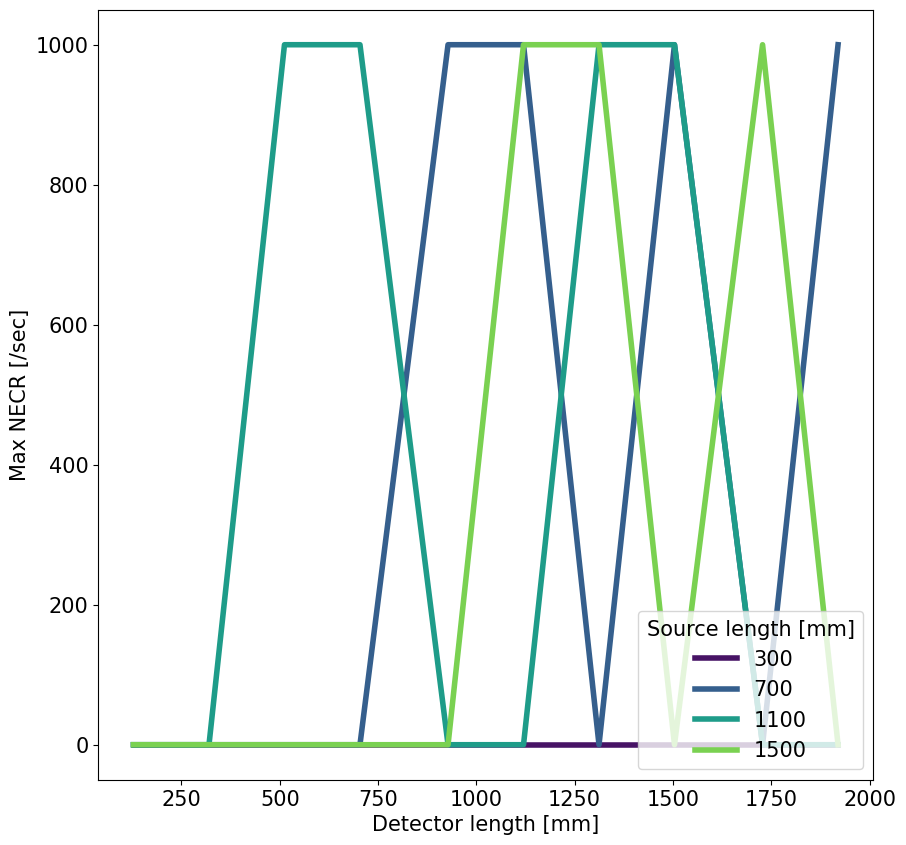

In [16]:
for i, phantomLength in enumerate( trialPhantoms ):
    mpl.plot( detectorLengths, maxNECRlines[i], label=phantomLength, linewidth=4.0 )

mpl.xlabel( "Detector length [mm]" )
mpl.ylabel( "Max NECR [/sec]" )
mpl.legend( trialPhantoms, title="Source length [mm]" )
mpl.gcf().set_size_inches( 10, 10 )
mpl.show()

Illustrate the scaling of NECR up to the source length, and beyond

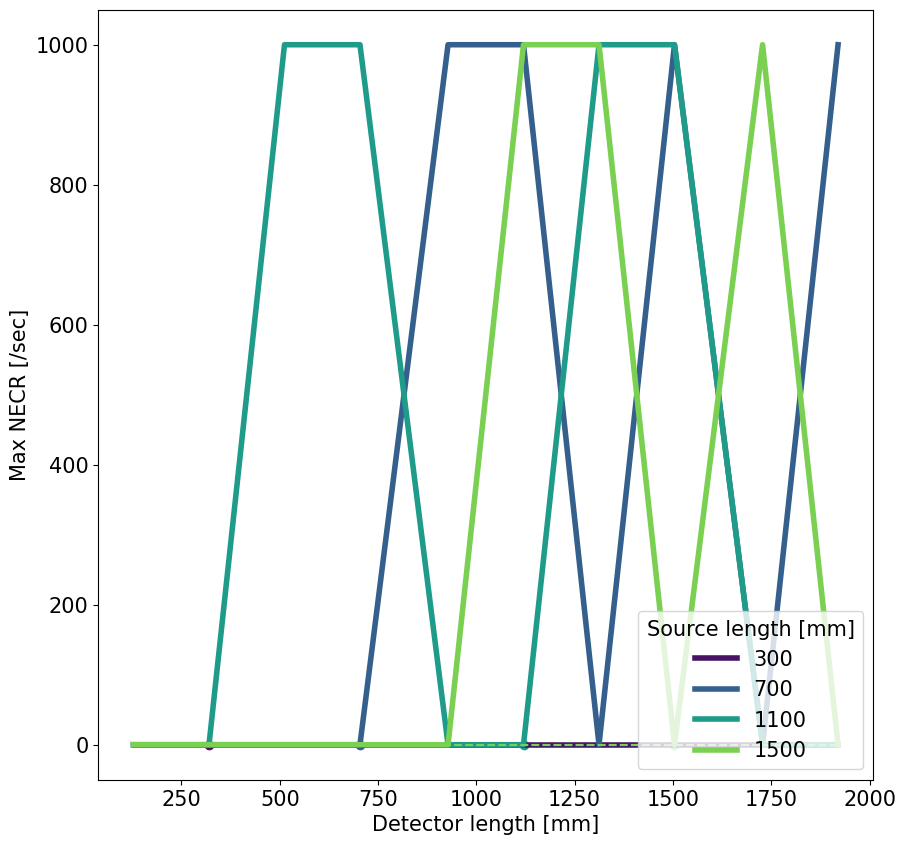

In [17]:
def scale( y0, y1, x1 ):
    m = (y1 - y0) / (x1 - detectorLengths[0])
    y2 = m * ( detectorLengths[-1] - x1 )
    y2 += y1
    return [ y0, y2 ]

def plotThreeParts( xs, ys, i, label, colour ):
    theplot, = mpl.plot( xs, ys, label=label, color=colour, linewidth=4.0 )
    mpl.plot( [xs[0], xs[-1]], scale(ys[0], ys[i], xs[i]), label="_", color=colour, linestyle="dashed" )
    mpl.scatter( [xs[i]], [ys[i]], label="_", color=colour )
    return theplot

legendEntries = []
for i, trialPhantom in enumerate( trialPhantoms ):
    
    # find the detector length index closest to the source length
    detectorLengthIndex = 0
    while detectorLengths[ detectorLengthIndex ] < trialPhantom:
        detectorLengthIndex += 1
    
    theplot = plotThreeParts( detectorLengths, maxNECRlines[i], detectorLengthIndex, trialPhantoms[i], myColours[i] )
    legendEntries.append( theplot )

mpl.xlabel( "Detector length [mm]")
mpl.ylabel( "Max NECR [/sec]")
mpl.legend( legendEntries, trialPhantoms, title="Source length [mm]" )
mpl.gcf().set_size_inches(10,10)
#mpl.ylim( [0.0, 2.5e6] )
mpl.show()